In [1]:
from obs_models import *
from generate_data import *
from utils import *
%matplotlib inline

In [2]:
from scipy.stats import multivariate_normal

In [3]:
N, D = 1000, 10
random_locs = np.random.randn(D)*10
random_covariance_factor = np.random.rand(D,D)*np.random.randint(2,size=D*D).reshape(D,D)
random_covariance = np.matmul(random_covariance_factor,random_covariance_factor.T)
random_data = multivariate_normal(mean=random_locs,cov=random_covariance).rvs(size=N)

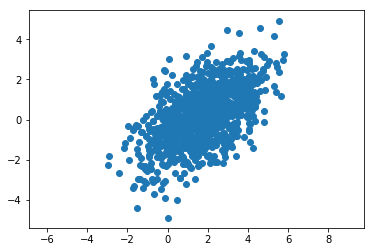

In [4]:
# plot two random dimensions against each other
pyplot.scatter(*random_data[:,np.random.choice(np.arange(D),size=2,replace=False)].T)
pyplot.axis('equal');

In [5]:
class IndependentGaussian:
    """Gaussian observations with no latent structure"""
    def __init__(self, X):
        if not type(X) is torch.Tensor:
            X = torch.Tensor(X)
        self.X = X
        self.N, self.D = X.shape
        self.conditioned_model = None
        
    def __repr__(self):
        return 'G'
    
    def model(self, X):
        with pyro.plate('D', self.D):
            loc = pyro.sample('loc', dst.Normal(0.,10.))
            scale = pyro.sample('scale', dst.LogNormal(0.,4.))
            with pyro.plate('N', self.N):
                X = pyro.sample('obs', dst.Normal(loc,scale))
        return X
    
    def conditionModel(self, X):
        if self.conditioned_model is None:
            self.conditioned_model = pyro.condition(self.model, data = {'obs': X})
        return self.conditioned_model(X)
    
    def guide(self, X):
        # MAP
        with pyro.plate('D', self.D):
            loc_delta = pyro.param('loc_delta', torch.zeros(self.D))
            scale_delta = pyro.param('scale_delta', torch.ones(self.D), constraint=constraints.positive)
            loc = pyro.sample('loc', dst.Delta(loc_delta))
            scale = pyro.sample('scale', dst.Delta(scale_delta))
        return loc, scale
    
    @pyro.ops.jit.trace
    def model_log_prob_fn(self):
        tr = pyro.poutine.trace(self.conditioned_model).get_trace(self.X)
        return tr.log_prob_sum()
        
    def inference(self):
        X = self.X
        self.conditionModel(X)
        def per_param_callable(module_name, param_name):
            #if param_name == 'loc_mean':
            #    return {"lr": 0.0, 'betas': [0.9, 0.99]}
            #else:
            #    return {"lr": 0.01, 'betas': [0.9, 0.99]}
            
            # I expect the initalization to be excellent, so set both lr and momentum to be low
            return {"lr": 0.001, 'betas': [0.9, 0.9]}

        def initialize(seed):
            # evaluate loss on a randomly initialized parameter-set 
            pyro.set_rng_seed(seed)
            pyro.clear_param_store()
            pyro.param('loc_delta', X.mean(0))
            pyro.param('scale_delta', X.std(0), constraint=constraints.positive)
            loss = self.svi.loss(self.conditioned_model, self.guide, self.X)
            return loss

        optim = pyro.optim.Adam(per_param_callable)
        elbo = Trace_ELBO()
        self.svi = SVI(self.conditioned_model, self.guide, optim, loss=elbo, num_samples=30)

        #loss, seed = min((initialize(seed), seed) for seed in range(100))
        initialize(np.random.randint(1000))
        
        # Register hooks to monitor gradient norms.
        self.gradient_norms = defaultdict(list)
        for name, value in pyro.get_param_store().named_parameters():
            value.register_hook(lambda g, name=name: self.gradient_norms[name].append(g.norm().item()))

        self.losses = []
        self.loc_evo = []
        self.scale_evo = []
        for i in range(500):
            loss = self.svi.step(X)
            self.losses.append(loss)
            self.loc_evo.append(pyro.param('loc_delta').detach().numpy())
            self.scale_evo.append(pyro.param('scale_delta').detach().numpy())
            print('.' if i % 100 else '\n', end='')
        self.params = pyro.get_param_store()
    
    def plot_learning_curve(self):
        pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
        pyplot.plot(self.losses)
        pyplot.xlabel('iters')
        pyplot.ylabel('loss')
        pyplot.yscale('log')
        pyplot.title('Convergence of SVI');
        
    def plot_gradient_norms(self):
        pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
        for name, grad_norms in self.gradient_norms.items():
            pyplot.plot(grad_norms, label=name)
        pyplot.xlabel('iters')
        pyplot.ylabel('gradient norm')
        pyplot.yscale('log')
        pyplot.legend(loc='best')
        pyplot.title('Gradient norms during SVI');
        
    def predictive_check(self):
        guide_trace = pyro.poutine.trace(self.guide).get_trace(self.X)
        posterior_predictive = pyro.poutine.replay(self.model, guide_trace)
        return posterior_predictive(self.X).detach().numpy()

In [6]:
tmp = IndependentGaussian(random_data)

In [7]:
# trace of conditioned model is empty?
#trace = pyro.poutine.trace(tmp.conditioned_model).get_trace()
trace = pyro.poutine.trace(tmp.model).get_trace(random_data)

In [8]:
trace.log_prob_sum()

tensor(-30797.7461)

In [9]:
tmp.inference()


...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

In [10]:
list(pyro.get_param_store().items())

[('loc_delta',
  tensor([ 4.3810, -0.4422,  8.3734, -1.7278,  0.1932, 12.2521,  1.7164, -0.9638,
          -3.5428, 11.8781], requires_grad=True)),
 ('scale_delta',
  tensor([1.0685, 1.4175, 1.1856, 1.5907, 1.3978, 0.7849, 1.4922, 1.3063, 1.7852,
          1.7827], grad_fn=<AddBackward0>))]

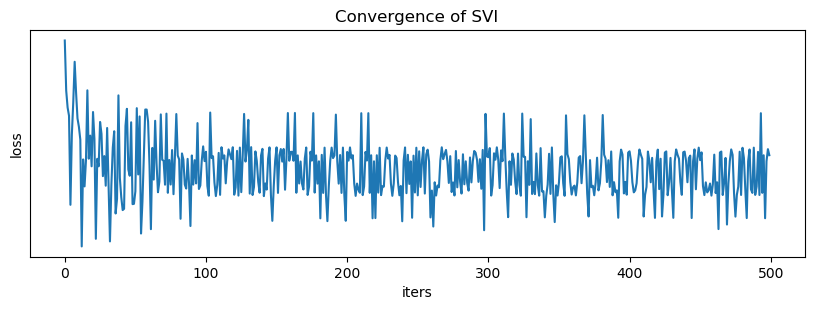

In [11]:
tmp.plot_learning_curve()

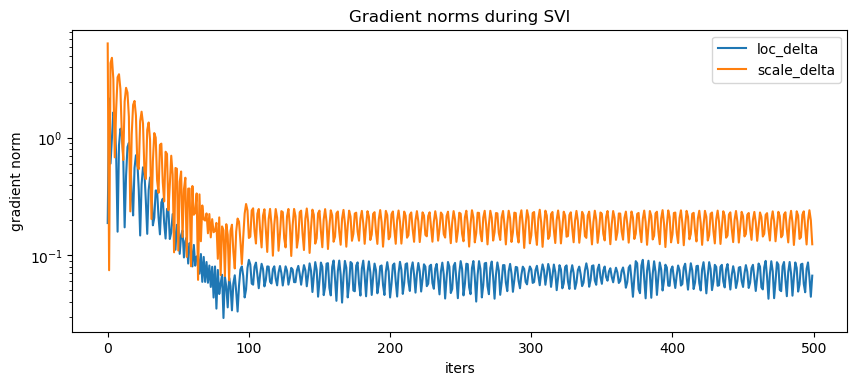

In [12]:
tmp.plot_gradient_norms()

In [13]:
loc_evo = np.array(tmp.loc_evo)

In [14]:
loc_evo.shape

(500, 10)

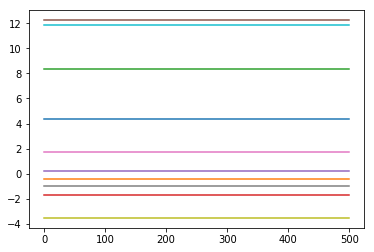

In [15]:
pyplot.plot(loc_evo)

In [16]:
scale_evo = np.array(tmp.scale_evo)

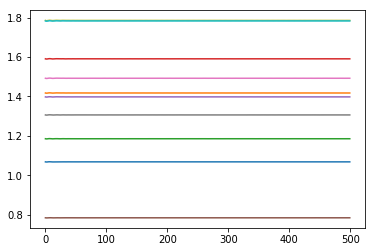

In [17]:
pyplot.plot(scale_evo)

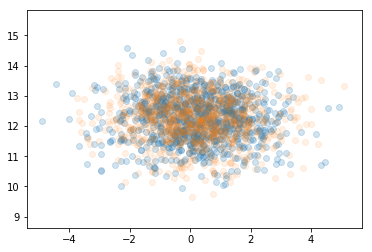

In [18]:
# plot two random dimensions against each other
random_idx = np.random.choice(np.arange(D),size=2,replace=False)
pyplot.scatter(*random_data[:,random_idx].T, alpha=.2)
pyplot.scatter(*tmp.predictive_check()[:,random_idx].T, alpha=.1)
pyplot.axis('equal');

In [19]:
# G -> GG + G
# input: A compositional model containing a G in the model and the guide, simplest case an Independent Gaussian
# output: A compositional model, where the Gs are replaced by GG + G, learning rates for other parameters are 0
#
# How to identify that there is a G? In the __repr__
# How to copy old model and guide, and replace the right parts?
# for Independent Gaussian -> Factor Analysis, it means replacing 
# X = pyro.sample('obs', dst.Normal(loc,scale))
# with
# X = pyro.sample('obs', dst.LowRankMultivariateNormal(loc, cov_factor=cov_factor, cov_diag=cov_diag))
# and adding sample sites for cov_factor and cov_diag
# 
# Just replace the whole model with a new one

In [20]:
tmp.params['loc_delta']

tensor([ 4.3810, -0.4422,  8.3734, -1.7278,  0.1932, 12.2521,  1.7164, -0.9638,
        -3.5428, 11.8781], requires_grad=True)

In [21]:
class LowRankGaussian:
    """Gaussian obervations with low rank covariance matrix"""
    def __init__(self, X, parent = None):
        if not type(X) is torch.Tensor:
            X = torch.Tensor(X)
        self.X = X
        self.N, self.D = X.shape
        self.conditioned_model = None
        self.parent = parent
        self.lock = True
        
    def __repr__(self):
        return 'GG + G'
    
    def model(self, X):
        cov_factor = torch.zeros((D,D))
        with pyro.plate('D', self.D) as d:
            loc = pyro.sample('loc', dst.Normal(0.,10.))
            cov_diag = pyro.sample('cov_diag', dst.LogNormal(0.,4.))
            cov_factor_column = pyro.sample('cov_factor_column', dst.Normal(torch.zeros(D),10.).to_event(1))
            cov_factor[:,d] = cov_factor_column
        with pyro.plate('N', self.N):
            X = pyro.sample('obs', dst.LowRankMultivariateNormal(loc, cov_factor=cov_factor, cov_diag=cov_diag))
        return X
    
    def conditionModel(self, X):
        if self.conditioned_model is None:
            self.conditioned_model = pyro.condition(self.model, data = {'obs': X})
        return self.conditioned_model(X)
    
    def guide(self, X):
        # mean field
        K = self.D
        cov_factor = torch.zeros((D,D))
        with pyro.plate('D', self.D) as d:
            # define parameters
            loc_mean = pyro.param('loc_mean', torch.zeros(D, requires_grad = False))
            loc_scale = pyro.param('loc_scale', torch.ones(D), constraint=constraints.positive)
            cov_factor_mean = pyro.param('cov_factor_mean', torch.zeros(D,K))
            cov_factor_scale = pyro.param('cov_factor_scale', torch.ones(D,K), constraint=constraints.positive)
            cov_diag_mean = pyro.param('cov_diag_mean', torch.zeros(D))
            cov_diag_scale = pyro.param('cov_diag_scale', torch.ones(D), constraint=constraints.positive)
            # sample variables
            loc = pyro.sample('loc', dst.Normal(loc_mean,loc_scale))
            cov_factor_column = pyro.sample('cov_factor_column', dst.Normal(cov_factor_mean, cov_factor_scale).to_event(1))
            cov_factor[:,d] = cov_factor_column
            cov_diag = pyro.sample('cov_diag', dst.LogNormal(cov_diag_mean, cov_diag_scale))
        return loc, cov_factor, cov_diag
    
    @pyro.ops.jit.trace
    def model_log_prob_fn(self):
        tr = pyro.poutine.trace(self.conditioned_model).get_trace(self.X)
        return tr.log_prob_sum()
        
    def inference(self, n_iter = 500):
        def per_param_callable(module_name, param_name):
            #if param_name in ['loc_mean']:
            if self.lock and param_name in ['loc_mean', 'cov_diag_mean']:
                return {"lr": 0.0, 'betas': [0.9, 0.99]}
            else:
                return {"lr": 0.01, 'betas': [0.9, 0.99]}

        def initialize(seed):
            # evaluate loss on a randomly initialized parameter-set 
            pyro.set_rng_seed(seed)
            pyro.param('loc_mean', self.parent.params['loc_delta'])
            pyro.param('cov_diag_mean', self.parent.params['scale_delta'], constraint=constraints.positive)
            #pyro.clear_param_store()
            loss = self.svi.loss(self.conditioned_model, self.guide, self.X)
            return loss

        self.conditionModel(self.X)
        optim = pyro.optim.Adam(per_param_callable)
        elbo = Trace_ELBO()
        self.svi = SVI(self.conditioned_model, self.guide, optim, loss=elbo)

        #loss, seed = min((initialize(seed), seed) for seed in range(100))
        if self.lock:
            initialize(np.random.randint(1000))
            # Register hooks to monitor gradient norms.
            self.losses = []
            self.gradient_norms = defaultdict(list)
        
        for name, value in pyro.get_param_store().named_parameters():
            value.register_hook(lambda g, name=name: self.gradient_norms[name].append(g.norm().item()))

        #self.loc_evo = []
        for i in range(n_iter):
            loss = self.svi.step(self.X)
            self.losses.append(loss)
            #self.loc_evo.append(pyro.param('loc').detach().numpy())
            print('.' if i % 100 else '\n', end='')
        
        # after initializing model in parent-model, finetune it
        if self.lock:
            self.lock = False
            print("\n")
            print("Finetuning")
            self.inference(n_iter = 1000)
    
    def plot_learning_curve(self):
        pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
        pyplot.plot(self.losses)
        pyplot.xlabel('iters')
        pyplot.ylabel('loss')
        pyplot.yscale('log')
        pyplot.title('Convergence of SVI');
        
    def plot_gradient_norms(self):
        pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
        for name, grad_norms in self.gradient_norms.items():
            pyplot.plot(grad_norms, label=name)
        pyplot.xlabel('iters')
        pyplot.ylabel('gradient norm')
        pyplot.yscale('log')
        pyplot.legend(loc='best')
        pyplot.title('Gradient norms during SVI');
        
    def predictive_check(self):
        guide_trace = pyro.poutine.trace(self.guide).get_trace(self.X)
        posterior_predictive = pyro.poutine.replay(self.model, guide_trace)
        return posterior_predictive(self.X).detach().numpy()

In [22]:
fa = LowRankGaussian(random_data, parent=tmp)

In [23]:
fa.inference()


...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

Finetuning

...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
......................................................................................

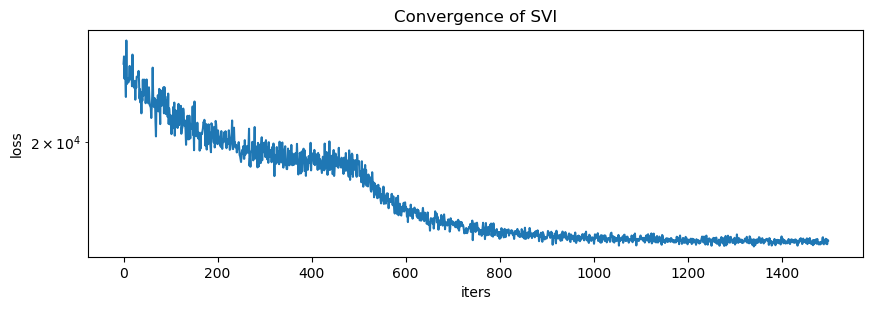

In [24]:
fa.plot_learning_curve()

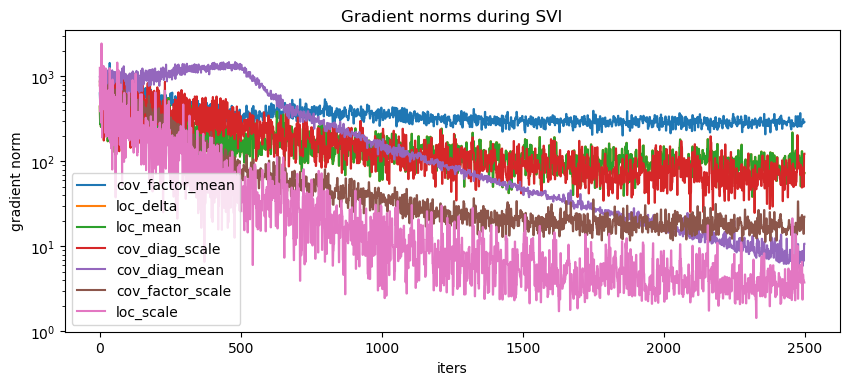

In [25]:
fa.plot_gradient_norms()

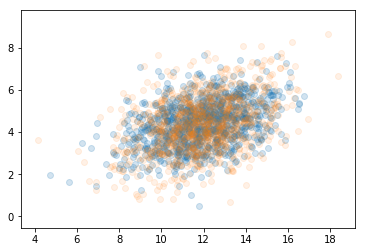

In [46]:
# plot two random dimensions against each other
random_idx = np.random.choice(np.arange(D),size=2,replace=False)
pyplot.scatter(*random_data[:,random_idx].T, alpha=.2)
pyplot.scatter(*fa.predictive_check()[:,random_idx].T, alpha=.1)
pyplot.axis('equal');

In [27]:
[item for item in pyro.get_param_store().items()]

[('loc_delta',
  tensor([ 4.3807, -0.4453,  8.3691, -1.7183,  0.2021, 12.2707,  1.7048, -0.9719,
          -3.5332, 11.8706], requires_grad=True)),
 ('scale_delta',
  tensor([1.0685, 1.4175, 1.1856, 1.5907, 1.3978, 0.7849, 1.4922, 1.3063, 1.7852,
          1.7827], grad_fn=<AddBackward0>)),
 ('loc_mean',
  tensor([ 4.3807, -0.4453,  8.3691, -1.7183,  0.2021, 12.2707,  1.7048, -0.9719,
          -3.5332, 11.8706], requires_grad=True)),
 ('cov_diag_mean',
  tensor([0.0085, 0.0105, 0.0117, 0.0211, 0.0093, 0.0048, 0.0154, 0.0100, 0.0259,
          0.1778], grad_fn=<AddBackward0>)),
 ('loc_scale',
  tensor([0.0382, 0.0401, 0.0341, 0.0401, 0.0368, 0.0327, 0.0406, 0.0427, 0.0444,
          0.0410], grad_fn=<AddBackward0>)),
 ('cov_factor_mean',
  tensor([[-0.4453,  0.0883, -0.0069, -0.0432, -0.0530, -0.2830, -0.1014, -0.1698,
            0.4427,  0.0853],
          [-0.6042,  0.1076, -0.0229,  0.7550,  0.2395, -0.3945,  0.2829, -0.3962,
           -0.0237,  0.2572],
          [-0.3536, -0.166

In [48]:
?dst.MixtureOfDiagNormalsSharedCovariance